In [15]:
# Import packages for Section 2.0 Catalog Access
from lsst.rsp import get_tap_service, retrieve_query
# Import packages for Section 3.0 Image Access
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler
import lsst.geom
import matplotlib.pyplot as pl
from matplotlib.colors import LogNorm
from scipy.stats import norm
import lsst.geom as geom
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib
import time
import h5py
import sys
sys.path.append('/home/philholloway/sim-pipeline/slsim/Util/')
from param_util import random_ra_dec
service = get_tap_service("tap")
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
skymap = butler.get("skyMap")

In [2]:
#From here: https://github.com/LSST-strong-lensing/slsim/blob/d8769446fb6aab699b6e18d5466e5aed2d589815/slsim/lsst_science_pipeline.py#L551
def tap_query(center_coords, radius=0.1, band="i"):
 
    """This function uses tap_service from RSP to query calexp visit information around
    a coordinate point.

    :param center_coords: A coordinate point around which visit informations are needed.
    :type center_coords: string. eg: "65, -36"
    :param radius: Radius around center point for query. The unit of radius is degree.
    :param band: imaging band
    :return: An astropy table of visit information sorted with observation time.
    """
    service = get_tap_service("tap")
    query = (
        "SELECT TOP 1 ra, decl,"
        + "ccdVisitId, band, "
        + "visitId, physical_filter, detector, "
        + "expMidptMJD, expTime, zeroPoint, skyRotation "
        + "FROM dp02_dc2_catalogs.CcdVisit "
        + "WHERE CONTAINS(POINT('ICRS', ra, decl), "
        + "CIRCLE('ICRS', "
        + center_coords
        + ", "
        + radius
        + ")) = 1"
        + "AND band = "
        + "'"
        + str(band)
        + "' "
    )
    result = service.search(query)
    result_table = result.to_table()
    sorted_column = np.argsort(result_table["expMidptMJD"])
    expo_information = result_table[sorted_column]
    return expo_information

#From here: https://github.com/LSST-strong-lensing/slsim/blob/d8769446fb6aab699b6e18d5466e5aed2d589815/slsim/Util/param_util.py#L60
def random_radec_string(ra_min, ra_max, dec_min, dec_max, n):
    """Generates n number of random "ra, dec" string within given limits.

    :param ra_min: minimum limit for ra
    :param ra_max: maximum limit for ra
    :param dec_min: minimum limit for dec
    :param dec_max: maximum limit for dec
    :param n: number of random sample
    :returns: n number of "ra, dec" strings within given limits
    """
    ra, dec = random_ra_dec(
        ra_min=ra_min, ra_max=ra_max, dec_min=dec_min, dec_max=dec_max, n=n
    )
    center_coods_list = []
    for i in range(n):
        center_coods_list.append(str(ra[i]) + ", " + str(dec[i]))
    return center_coods_list

In [ ]:
#The LSST Science Camera has 189 science detectors (i.e. np.arange(0,189,1)).
'''
for detector in tqdm(np.arange(0,189,10).astype('int')):
    datasetRefs = registry.queryDatasets(datasetType='calexp', band='i', detector=detector,
                                     where='visit > 0 and visit < 1000000000')
    for i, ref in enumerate(datasetRefs):
        if i%1000!=0: continue
        calexp = butler.get('calexp', dataId={'visit': ref.dataId.full['visit'], 'detector': detector})
        mag_zp = calexp.getPhotoCalib().instFluxToMagnitude(1)
        ZP_list.append(mag_zp)
        print(detector,mag_zp)'''

#From Narayan: The DP0 has RA/Dec limits of RA:55=>70 and Dec:-43=> 30
N_ZP = 10000
ZP_list = []
for n in tqdm(range(N_ZP)):
    ZP_list.append(tap_query((random_radec_string(55,70,-43,-30,1)[0]),radius = str(1))['zeroPoint'][0])

In [ ]:
fig = pl.subplots(figsize=(8,5))
pl.hist(ZP_list,bins=20,edgecolor='k')
pl.xlabel('Zeropoint',fontsize=15)
pl.ylabel('Counts',fontsize=15)
pl.title('$\mu=$'+f'{str(np.round(np.mean(ZP_list),3))}, '+'$\sigma=$'+f'{str(np.round(np.std(ZP_list),3))}')
pl.savefig(f'./DP0_Zeropoint_Distribution_{N_ZP}.png')
pl.show()

In [ ]:
np.round(np.std(ZP_list),2)

In [ ]:
'''
service = get_tap_service("tap")
table_full_name = 'dp01_dc2_catalogs.object'
query = """SELECT DISTINCT tract FROM %s ORDER BY tract""" % (table_full_name)
query_p = """SELECT DISTINCT patch FROM %s ORDER BY patch""" % (table_full_name)
results = service.search(query)
results_p = service.search(query_p)
df = results.to_table().to_pandas()
df_p =  results_p.to_table().to_pandas()
tract_list = df['tract'].tolist()
patch_list = df_p['patch'].tolist()'''


In [ ]:
exp_time_list = [];mean_list = [];std_list =[];tp_list = []

butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
skymap = butler.get('skyMap')
N_coadd = 10000
ra_dec_list = random_ra_dec(55,70,-43,-30,N_coadd)

for n in tqdm(range(len(ra_dec_list[0]))):
    ra_i = ra_dec_list[0][n]
    dec_i =ra_dec_list[1][n]
    my_spherePoint = lsst.geom.SpherePoint(ra_i*lsst.geom.degrees,
                                           dec_i*lsst.geom.degrees)
    tract = skymap.findTract(my_spherePoint)
    patch = tract.findPatch(my_spherePoint)
    my_tract = tract.tract_id
    my_patch = patch.getSequentialIndex() 
    exp_map = butler.get("deepCoadd_nImage",dataId={"tract": (my_tract),
                                                                 "patch": (my_patch), "band": "i"})
    mean_i,std_i = np.mean(exp_map.array),np.std(exp_map.array)
    mean_list.append(mean_i);std_list.append(std_i);tp_list.append([my_tract,my_patch])
    X_plot_i = np.linspace(mean_i-5*std_i,mean_i+5*std_i,1000)
    #ax.plot(X_plot_i,norm.pdf(X_plot_i,loc=mean_i,scale=std_i),c='k',alpha=0.1)

#pl.show()

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
for i in tqdm(range(len(mean_list))):
    mean_i = mean_list[i]
    std_i = std_list[i]
    X_plot_i = np.linspace(mean_i-5*std_i,mean_i+5*std_i,1000)
    ax[0].plot(X_plot_i,norm.pdf(X_plot_i,loc=mean_i,scale=std_i),c='k',alpha=1,linewidth=0.01)
ax[0].set_xlim(left=0)
ax[1].hist(mean_list,bins=np.arange(0,np.max([150,max(mean_list)]),10),edgecolor='k')
ax[2].hist(std_list,bins=np.arange(0,np.max([30,max(std_list)]),2),edgecolor='k')
ax[0].set_xlabel('Number of Exposures',fontsize=15)
ax[1].set_xlabel('Mean N. Exposures per pixel',fontsize=15)
ax[2].set_xlabel('Spread in N. Exposures per pixel',fontsize=15)
for p_i in range(3):
    ax[p_i].tick_params(labelsize=15)
    if p_i>=1: ax[p_i].set_ylabel('Counts',fontsize=15)
    else: ax[p_i].set_ylabel('Probability Density',fontsize=15)

pl.tight_layout()
pl.savefig(f'./DP0_N_Exposure_Distribution_{N_coadd}.png')
pl.show()


In [ ]:
ra = 62.541629  # degrees
dec = -37.852021  # degrees
point = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(201, 201)
# print(cutoutSize)

# Read this from the table we have at hand...
tractInfo = skymap.findTract(point)
patchInfo = tractInfo.findPatch(point)
my_tract = tractInfo.tract_id
my_patch = patchInfo.getSequentialIndex()

xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))

bbox = geom.BoxI(xy + cutoutSize // 2, cutoutSize)

coaddId_i = {"tract": 3638, "patch": 27, "band": "i"}
coadd_cut_i = butler.get("deepCoadd", parameters={"bbox": bbox}, dataId=coaddId_i)
coadd_exp_i = butler.get("deepCoadd_nImage", parameters={"bbox": bbox}, dataId=coaddId_i)

In [ ]:
(coadd_cut_i.image).writeFits('./test_fitsfile.fits','ac')

from astropy.io import fits
a=fits.open('./test_fitsfile.fits')
a[0].header

In [ ]:
help(coadd_cut_i.image.writeFitsWithOptions)
#(coadd_cut_i.image)

In [ ]:
(coadd_cut_i).getPsf()

In [ ]:
#selection function.

In [ ]:
psf.computeKernelImage(position=spt)

In [ ]:
dp0_image = coadd_cut_i
wcs = dp0_image.getWcs()
psf = dp0_image.getPsf()
bbox = dp0_image.getBBox()
pixscale = wcs.getPixelScale(bbox.getCenter()).asArcseconds()
num_pix_cutout = np.shape(dp0_image.image.array)[0]
cutout_num=-1
calibFluxRadius=12
bbox = dp0_image.getBBox()

xmin, ymin = bbox.getBegin()
xmax, ymax = bbox.getEnd()
print(xmax-xmin,ymax-ymin)
wcs = dp0_image.getWcs()
print(xmin+150,xmax-150,ymax)
#x_center = np.random.randint(xmin + 150, xmax - 150, 1)
#y_center = np.random.randint(ymin + 150, ymax - 150, 1)
spt = geom.Point2D(0.5*(xmin+xmax),0.5*(ymin+ymax))
cutout_num+=1
#num_pix_lens = np.shape(lens)[0]
pt = spt
psfArr = psf.computeKernelImage(pt).array
apCorr = psf.computeApertureFlux(calibFluxRadius, pt)

psfArr /= apCorr


{'1-2': 0.0005395412445068359, '2-3': 4.004901170730591, '4-3': 5.105464458465576}


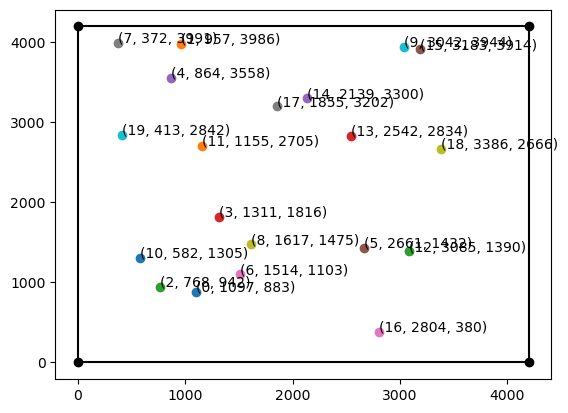

[(57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57), (57, 57)]


In [91]:
class retrieve_coadds():
    def __init__(self,ra=None,dec=None,cutout_size=201,n_im_per_coadd = 10):
        if ra is None or dec is None:
            ra_dec_list = random_ra_dec(55,70,-43,-30,1) #Retrieve random RA/Dec
            self.ra = ra_dec_list[0];self.dec=ra_dec_list[1]
            self.cutout_size=cutout_size
            self.n_im_per_coadd=n_im_per_coadd

    def retrieve_tract_patch(self,ra,dec):
        point = geom.SpherePoint(ra, dec, geom.degrees)
        cutoutSize = geom.ExtentI(self.cutout_size, self.cutout_size)
        # Read this from the table we have at hand...
        tractInfo = skymap.findTract(point)
        patchInfo = tractInfo.findPatch(point)
        my_tract = tractInfo.tract_id
        my_patch = patchInfo.getSequentialIndex()
        return my_tract,my_patch,point,tractInfo,cutoutSize
    
    def retrieve_coadd_files(self,tract,patch,point,tractInfo,cutoutSize):
        xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))
        coaddId_i = {"tract": tract, "patch": patch, "band": "i"}
        coadd_cut_i = butler.get("deepCoadd", dataId=coaddId_i)
        coadd_exp_i = butler.get("deepCoadd_nImage", dataId=coaddId_i)
        #
        bbox_coadd = coadd_cut_i.getBBox()
        xmin, ymin = bbox_coadd.getBegin()
        xmax, ymax = bbox_coadd.getEnd()
        #Why is this +- 150? Question for Narayan! Code adapted from lens_inejection_fast function.
        x_center = np.random.randint(xmin + 150, xmax - 150, self.n_im_per_coadd)
        y_center = np.random.randint(ymin + 150, ymax - 150, self.n_im_per_coadd)
        xbox_min = x_center - ((self.cutout_size - 1) / 2)
        xbox_max = x_center + ((self.cutout_size - 1) / 2)
        ybox_min = y_center - ((self.cutout_size - 1) / 2)
        ybox_max = y_center + ((self.cutout_size - 1) / 2)
        bbox_cutout_list = [];spt_cutout_list = []
        for n_cutouts in range(len(x_center)):
            bbox_cutout_i = geom.Box2I(
                                geom.Point2I(xbox_min[n_cutouts], ybox_min[n_cutouts]),
                                geom.Point2I(xbox_max[n_cutouts], ybox_max[n_cutouts]))
            spt_i = geom.Point2D(0.5*(xbox_min[n_cutouts]+xbox_max[n_cutouts]),
                               0.5*(ybox_min[n_cutouts]+ybox_max[n_cutouts]))
            bbox_cutout_list.append(bbox_cutout_i)
            spt_cutout_list.append(spt_i)
            #print(bbox_cutout_i,spt_i)
        return coadd_cut_i,coadd_exp_i,bbox_cutout_list,spt_cutout_list
    #
    def retrieve_arrays(self):
        t1=time.time()
        tract,patch,point,tractInfo,cutoutSize = self.retrieve_tract_patch(self.ra,self.dec)
        t2=time.time()
        coadd_im,coadd_exp,bbox_cutout_list,spt_cutout_list = self.retrieve_coadd_files(tract,patch,point,tractInfo,cutoutSize)
        t3=time.time()
        wcs = coadd_im.getWcs()
        psf = coadd_im.getPsf()
        bbox = coadd_im.getBBox()
        pixscale = wcs.getPixelScale(bbox.getCenter()).asArcseconds()
        xmin, ymin = bbox.getBegin()
        xmax, ymax = bbox.getEnd()
###
        calibFluxRadius=12
        psf_list = [];cutout_list = [];cutout_exp_list = []
        for n_cutouts in range(len(bbox_cutout_list)):
            bbox_cutout_i = bbox_cutout_list[n_cutouts]
            spt_cutout_i = spt_cutout_list[n_cutouts]
            pl.scatter(spt_cutout_i.x-bbox.minX,spt_cutout_i.y-bbox.minY)
            pl.text(spt_cutout_i.x-bbox.minX,spt_cutout_i.y-bbox.minY,s=(n_cutouts,int(spt_cutout_i.x-bbox.minX),int(spt_cutout_i.y-bbox.minY)))
            cutout_image = coadd_im[bbox_cutout_i]
            cutout_exp = coadd_exp[bbox_cutout_i]
            psfArr = psf.computeKernelImage(spt_cutout_i).array
            apCorr = psf.computeApertureFlux(calibFluxRadius, spt_cutout_i)
            psfArr /= apCorr
            psf_list.append(psfArr)
            cutout_list.append(cutout_image.image.array)
            cutout_exp_list.append(cutout_exp.array)
        t4=time.time()
        print({'1-2':t2-t1,'2-3':t3-t2,'4-3':t4-t3})
        pl.plot([0]*2,[0,bbox.maxY-bbox.minY],c='k')
        pl.plot([bbox.maxX-bbox.minX]*2,[0,bbox.maxY-bbox.minY],c='k')
        pl.plot([0,bbox.maxX-bbox.minX],[0]*2,c='k')
        pl.plot([0,bbox.maxX-bbox.minX],[bbox.maxY-bbox.minY]*2,c='k')
        pl.scatter([0,0,bbox.maxX-bbox.minX,bbox.maxX-bbox.minX],[0,bbox.maxY-bbox.minY,0,bbox.maxY-bbox.minY],c='k')
        pl.show()
        return cutout_list,cutout_exp_list,psf_list
    def save_arrays(self,foldername,prefix):
        cutout_list,cutout_exp_list,psf_list = self.retrieve_arrays()
        cutout_list=np.array(cutout_list)
        cutout_exp_list=np.array(cutout_exp_list)
        print([np.shape(elem) for elem in psf_list])
        psf_list=np.array(psf_list)
        if not os.path.isdir(foldername):
            os.mkdirs(foldername)
        with h5py.File(foldername+f'/{prefix}_image_data.h5', 'w') as hf:
            hf.create_dataset("data", data=cutout_list,compression="gzip", maxshape=(None,cutout_list.shape[1],cutout_list.shape[2])) 
        with h5py.File(foldername+f'/{prefix}_Nexp_data.h5', 'w') as hf:
            hf.create_dataset("data", data=cutout_exp_list,compression="gzip", maxshape=(None,cutout_exp_list.shape[1],cutout_exp_list.shape[2])) 
        with h5py.File(foldername+f'/{prefix}_psf_data.h5', 'w') as hf:
            hf.create_dataset("data", data=psf_list,compression="gzip", maxshape=(None,psf_list.shape[1],psf_list.shape[2])) 
        return cutout_list,cutout_exp_list,psf_list
        
for i in range(1):
    a,b,c = retrieve_coadds(n_im_per_coadd=20).save_arrays('./1/','1')
    for i in range(0):
        fig,ax = pl.subplots(1,3,figsize=(15,5))
        ax[0].imshow(a[i],norm=LogNorm())
        ax[1].imshow(b[i])
        ax[2].imshow(c[i])
    pl.show()
#print(np.mean(b),np.std(b))